## Exercice 3 : Modèle K-NN pour la classification des données de CIFAR-10 avec PyTorch

### 1- Chargement des données

In [1]:
import os
import numpy as np
import torch
import torchvision
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt

### Fonction défini pour charger correctement les données
La première fonction _extract_tensors prend un ensemble de données dset en entrée et optionnellement un nombre num d'échantillons à extraire. Elle convertit les données d'entrée en tenseurs PyTorch, normalise les valeurs de pixel entre 0 et 1 en divisant par 255, et réorganise les dimensions des tenseurs pour correspondre à l'ordre attendu par PyTorch. Si num est spécifié, elle extrait seulement les num premiers échantillons de l'ensemble de données. La fonction retourne ensuite les tenseurs d'entrée x et les étiquettes y.<br>

La deuxième fonction cifar10 est une fonction de haut niveau qui utilise la fonction _extract_tensors pour charger les données CIFAR-10. Elle télécharge les données CIFAR-10 si elles ne sont pas déjà présentes sur le système, puis divise les données en ensembles d'entraînement et de test. Pour chaque ensemble, elle appelle _extract_tensors pour obtenir les tenseurs d'entrée et les étiquettes correspondantes. Elle retourne ensuite les ensembles d'entraînement et de test ainsi prétraités.

In [2]:
def _extract_tensors(dset, num=None):
  x = torch.tensor(dset.data, dtype=torch.float32).permute(0, 3, 1, 2).div_(255)
  y = torch.tensor(dset.targets, dtype=torch.int64)
  if num is not None:
     if num <= 0 or num > x.shape[0]:
        raise ValueError('Invalid value num=%d; must be in the range [0, %d]'
                       % (num, x.shape[0]))
     x = x[:num].clone()
     y = y[:num].clone()
  return x, y
      
def cifar10(num_train=None, num_test=None):
  download = not os.path.isdir('cifar-10-batches-py')
  dset_train = CIFAR10(root='.', download=download, train=True)
  dset_test = CIFAR10(root='.', train=False)
  x_train, y_train = _extract_tensors(dset_train, num_train)
  x_test, y_test = _extract_tensors(dset_test, num_test)
  
  return x_train, y_train, x_test, y_test

### Taille des données
L'ensemble de données CIFAR-10 contient 60 000 images couleur 32 x 32 réparties en 10 classes différentes. Les 10 classes différentes représentent les avions, les voitures, les oiseaux, les chats, les cerfs, les chiens, les grenouilles, les chevaux, les navires et les camions. Il y a 6 000 images de chaque classe. <br>
Pour notre modèle, nous définissons 50 000 images pour l'entrainement et 10 000 images pour le test

In [3]:
x_train, y_train, x_test, y_test = cifar10()

print("Taille des données d'entrainement:", x_train.shape)
print("Taille des étiquettes d'entrainement:", y_train.shape)

print("Taille des données de test:", x_test.shape)
print("Taille des étiquettes de test:", y_test.shape)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Taille des données d'entrainement: torch.Size([50000, 3, 32, 32])
Taille des étiquettes d'entrainement: torch.Size([50000])
Taille des données de test: torch.Size([10000, 3, 32, 32])
Taille des étiquettes de test: torch.Size([10000])


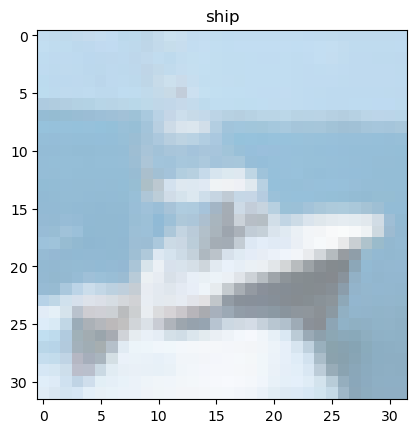

In [4]:
#Affichage d'une image aléatoire 
def imshow(i):
    a = x_train[i]
    torchvision.utils.make_grid(a)
    a = a / 2 + 0.5    
    npimg = a.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(classes[y_train[i]])
    plt.show()


imshow(8)

## 2- Construction de notre modèle K-NN

### Calcul des distances euclidiennes
La fonction <b> compute_distances_no_loops </b> calcule les distances euclidiennes entre chaque paire d'images entre l'ensemble d'entraînement (x_train) et l'ensemble de test (x_test). Au lieu d'utiliser des boucles explicites, Nous exploitons les opérations vectorielles de PyTorch pour effectuer les calculs de manière efficace.<br>
Notre approche se définit comme suit : <br>

- Obtention du nombre d'images dans les ensembles d'entraînement et de test <br>
- Création d'un tenseur dists de dimensions (num_train, num_test) rempli de zéros, où num_train est le nombre d'images dans l'ensemble d'entraînement et num_test est le nombre d'images dans l'ensemble de test. <br>
- Redisposer les tenseurs x_train et x_test pour qu'ils aient la forme (nombre_d'images, nombre_de_caractéristiques_par_image) en utilisant la méthode flatten. <br>
- Calcul des carrés des éléments des tenseurs train et test. <br>
- Sommation des éléments de chaque ligne des tenseurs train_sq et test_sq pour obtenir les sommes des carrés pour chaque image, respectivement. <br>
- Multiplication matricielle entre le tenseur train et la transposée du tenseur test pour obtenir les produits scalaires entre chaque paire d'images.<br>
- Calcul de la distance euclidienne entre chaque paire d'images à l'aide de la formule de distance euclidienne : <br> 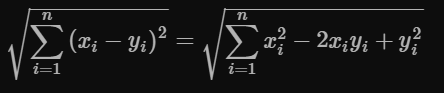


In [5]:
def compute_distances_no_loops(x_train, x_test):
  # Obtention du nombre d'images dans les ensembles d'entraînement et de test
  num_train = x_train.shape[0]
  num_test = x_test.shape[0]

  # Création d'un tenseur dists de dimensions (num_train, num_test) rempli de zéros
  dists = x_train.new_zeros(num_train, num_test) # (50000, 10000)

  train = x_train.flatten(1) # (50000, 3072)
  test = x_test.flatten(1) # (10000, 3072)

  # Calcul des carrés des éléments des tenseurs train et test
  train_sq = torch.square(train)
  test_sq = torch.square(test)

  # Sommation des éléments de chaque ligne des tenseurs
  train_sum_sq = torch.sum(train_sq, 1) # (50000)
  test_sum_sq = torch.sum(test_sq, 1) # (10000)

  # Multiplication matricielle entre le tenseur train et la transposée du tenseur test
  mul = torch.matmul(train, test.transpose(0, 1)) # (50000, 10000)


  # Calcul de la distance euclidienne entre chaque paire d'images
  dists = torch.sqrt(train_sum_sq.reshape(-1, 1) + test_sum_sq.reshape(1, -1) - 2*mul)
  print ("Calcul de la distance terminé !")
    
  return dists

In [6]:
# Stockage de la distance euclidienne
dists = compute_distances_no_loops(x_train, x_test)

Calcul de la distance terminé !


## 3- Prediction et evaluation des performances de notre modèle
Dans cette partie, nous implémentons un algorithme k-NN pour la classification des images dans l'ensemble de test en utilisant différentes valeurs de k et affichons la précision pour chaque valeur de k afin de trouver le nombre de voisins neccessaire qu'il faut utiliser pour que notre classification soit optimale

In [7]:
for k in range (1,6):
    k = k
    y_test_pred = torch.zeros(x_test.shape[0], dtype=torch.int64)
    
    for i in range(dists.shape[1]):
        # Trouver l'indice des k valeurs les plus basses
        x = torch.topk(dists[:,i], k, largest=False).indices
        
        # Valeur de l'index suivant x
        k_lowest_labels = y_train[x]
        
        # y_test_pred[i] = l'indice le plus fréquent
        y_test_pred[i] = torch.argmax(torch.bincount(k_lowest_labels))
    num_samples = x_test.shape[0]
    num_correct = (y_test == y_test_pred).sum().item()
    accuracy = 100.0 * num_correct / num_samples
    print(f'Avec K = {k}, On obtient {num_correct} / {num_samples} images correcte. Precision: {accuracy:.2f}%')

Avec K = 1, On obtient 3539 / 10000 images correcte. Precision: 35.39%
Avec K = 2, On obtient 3115 / 10000 images correcte. Precision: 31.15%
Avec K = 3, On obtient 3303 / 10000 images correcte. Precision: 33.03%
Avec K = 4, On obtient 3399 / 10000 images correcte. Precision: 33.99%
Avec K = 5, On obtient 3398 / 10000 images correcte. Precision: 33.98%


## Conclusion
Nous avons implementer un algorithme de classification k-plus proches voisins (k-NN) pour prédire les étiquettes des images dans l'ensemble de test des données de CIFAR-10. <br>
En utilisant cet algorithme avec des valeurs de k allant de 1 à 5, nous avons obtenu une meilleure précision de classification à k = 1 de 35.39%. Cette précision représente le pourcentage d'images correctement classées par rapport au nombre total d'images dans l'ensemble de test.<br>

Cette précision fournit une indication de la performance optimale de cette implémentation de l'algorithme k-NN sur ce jeu de données spécifique.